# Projet phylogénétique
Marine Djaffardjy (marine.djaffardjy@u-psud.fr)- Théophile Sanchez - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limités aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres). Vous n'avez pas besoin d'utiliser d'autre packages (pas de pandas).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- Faites des fonctions d'affichage pour vos matrices !!
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms (il faut que je puisse faire tourner les notebooks).

------
## Importation des séquences

Le format [FASTA](https://fr.wikipedia.org/wiki/FASTA_(format_de_fichier) permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écrivez une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire `seq_cat`. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.
Exportez le dictionnaire obtenu dans un fichier `output/dict_seq.json`.

In [1]:

def load_dict(filename):
    """
    Importe un fichier au format FASTA et le stocke dans un dictionnaire.
    Les clés sont les noms des séquences et les valeurs sont les séquences d'ADN.

    Args:
        filename (str): Le nom du fichier à importer.

    Returns:
        dict: Le dictionnaire des séquences.
    """
    seq_cat = {}
    file = open(filename)
    value=""
    for i, line in enumerate(file):
        if line[0]==">":
            label = line[1:]
        elif len(line)>1:
            value+=line.strip()
        else:
            seq_cat[label.strip()]=value
            value=""

    # Exportation du dictionnaire dans un fichier JSON
    with open("output/dict_seq.json", "w") as f:
        f.write(str(seq_cat))

    return seq_cat

# Exemple d'utilisation
#load_dict("input/cat_dna.fasta")

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [2]:
import numpy as np

class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('input/dna_matrix')


print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [3]:
similarity_matrix = SimilarityMatrix('input/dna_matrix')

def score_compare(a,b):
    score=0
    # On parcourt les deux séquences en parallèle et on ajoute le score de similarité entre chaque paire de lettres à la variable score
    for i in range(len(a)):
            score+=similarity_matrix.score(a[i],b[i])
    # On retourne le score final
    return score

# Exemples d'utilisation de la fonction score_compare avec différentes paires de séquences
print(score_compare("-ACTCCTGA","ATCTCGTGA")) #A1
print(score_compare("A-CTCCTGA","ATCTCGTGA")) #A2
print(score_compare("AC-TCCTGA","ATCTCGTGA")) #A3

35.0
49.0
39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [261]:
def algo(a, b, mat):
    
    # Initialisation des matrices M et T
    n, m = len(a), len(b)
    M = np.zeros((n+1,m+1))  # Matrice de score
    T = np.zeros((n+1,m+1))  # Matrice de traceback

    # Initialisation des valeurs de la première colonne et de la première ligne de la matrice M et de T
    for i in range(1, n+1):
        M[i][0] = -5 * i
        T[i][0] = 1
    for i in range(1, m+1):
        M[0][i] = -5 * i
        T[0][i] = 2
        
    # Remplissage de la matrice M avec l'algorithme de Needleman-Wunsch
    for i in range(n):
        for j in range(m):
            # Calcul du score pour chaque cellule de la matrice M
            M[i+1][j+1] = max(
                M[i][j] + mat.score(a[i], b[j]),
                M[i][j+1] + mat.score(a[i], "-"),
                M[i+1][j] + mat.score(b[j], "-")
            )
            
            # Traceback dans la matrice T en fonction de la cellule maximale de la matrice M
            if max(M[i][j] + mat.score(a[i], b[j]), M[i][j+1] + mat.score(a[i], "-"), M[i+1][j] + mat.score(b[j], "-")) == M[i][j+1] + mat.score(a[i], "-"):
                T[i+1][j+1] = 1  # Insertion dans la séquence b
            if max(M[i][j] + mat.score(a[i], b[j]), M[i][j+1] + mat.score(a[i], "-"), M[i+1][j] + mat.score(b[j], "-")) == M[i+1][j] + mat.score(b[j], "-"):
                T[i+1][j+1] = 2  # Insertion dans la séquence a
            if max(M[i][j] + mat.score(a[i], b[j]), M[i][j+1] + mat.score(a[i], "-"), M[i+1][j] + mat.score(b[j], "-")) == M[i][j] + mat.score(a[i], b[j]):
                T[i+1][j+1] = 3  # Correspondance

    # Reconstruction des séquences à partir de la matrice T
    S1 = ""
    S2 = ""
    while T[n][m] != 0:
        if T[n][m] == 3:
            S1 += a[n-1]
            S2 += b[m-1]
            n = n - 1
            m = m - 1
        if T[n][m] == 2:
            S1 += "-"
            S2 += b[m-1]
            m = m - 1
        if T[n][m] == 1:
            S1 += a[n-1]
            S2 += "-"
            n = n - 1

    # Inversion des séquences S1 et S2 pour obtenir les séquences alignées correctement
    S1 = "".join(reversed(S1))
    S2 = "".join(reversed(S2))
    L = [S1, S2]          
            
    return S1,S2


A,B=algo("ACTCCTGA","ATCTCGTGA",similarity_matrix)



----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor. Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [266]:
# Fonction qui calcule la matrice de distances entre des séquences ADN stockées dans un dictionnaire
def MatDist(Dic):
    
    # Récupération des clés et des valeurs du dictionnaire
    K = list(Dic.keys())
    V = list(Dic.values())
    
    # Initialisation de la matrice de distances
    M = np.zeros((len(K),len(K)))
    
    # Affichage des noms des séquences
    print("        ", end = " ")
    for i in range(len(K)):
        print(" | ", f"{K[i]:5.5}", end  = " ")
    print("\n")
    
    # Calcul de la distance entre les paires de séquences
    for i in range(len(K)):
        # Affichage du nom de la séquence
        print(" | ", f"{K[i]:5.5}", end = " ")
        for j in range(0, i):
            # Appel de la fonction 'algo' pour aligner les deux séquences
            A,B=algo(V[i],V[j],similarity_matrix)
            # Calcul de la distance entre les deux séquences alignées
            M[i][j] = p_distance(A,B)
            M[j][i] = p_distance(A,B)
            # Affichage de la distance dans la matrice de distances
            print(" | ", "{0:.3f}".format(M[i][j]), end = " ")
        # Aller à la ligne pour afficher la distance avec la séquence suivante
        print("\n")
    
    # Retourne la matrice de distances
    return M

# Fonction qui calcule la distance proportionnelle entre deux séquences ADN alignées
def p_distance(Seq1, Seq2):
    # Initialisation des variables
    count = 0
    countGap = 0
    a = len(Seq1)
    b = len(Seq2)
    # Calcul du nombre de substitutions
    for i in range(a) :
        if Seq1[i] != Seq2[i] and Seq1[i] != '-' and Seq2[i] != '-':
            count += 1
        # Calcul du nombre de gaps
        if Seq1[i] == '-':
            countGap += 1
        if Seq2[i] == '-':
            countGap += 1
    # Calcul de la distance proportionnelle
    count = count/(len(Seq1)-countGap)
    count = -(3/4)*np.log(1-(4/3)*count)
    # Retourne la distance proportionnelle
    return count

# Chargement du dictionnaire de séquences ADN
Dic = load_dict("input/cat_dna.fasta")

# Appel de la fonction pour calculer la matrice de distances entre les séquences ADN
MatDist(Dic)

          |  Saber  |  Homot  |  Ameri  |  Spott  |  Strip  |  Chine  |  Afric  |  Felis  |  Wild   |  Cheet  |  Puma   |  Tiger  |  Lion   |  Leopa  |  Dog D  |  Wolf   |  Black  |  Brown  |  Cave  

 |  Saber 

 |  Homot  |  0.140 

 |  Ameri  |  0.160  |  0.170 

 |  Spott  |  0.131  |  0.145  |  0.167 

 |  Strip  |  0.175  |  0.176  |  0.162  |  0.127 

 |  Chine  |  0.135  |  0.166  |  0.102  |  0.147  |  0.161 

 |  Afric  |  0.152  |  0.181  |  0.110  |  0.170  |  0.153  |  0.098 

 |  Felis  |  0.157  |  0.176  |  0.130  |  0.166  |  0.167  |  0.110  |  0.018 

 |  Wild   |  0.157  |  0.185  |  0.114  |  0.162  |  0.162  |  0.102  |  0.011  |  0.014 

 |  Cheet  |  0.157  |  0.176  |  0.078  |  0.175  |  0.132  |  0.115  |  0.106  |  0.118  |  0.110 

 |  Puma   |  0.187  |  0.206  |  0.055  |  0.198  |  0.202  |  0.123  |  0.139  |  0.160  |  0.143  |  0.090 

 |  Tiger  |  0.139  |  0.192  |  0.126  |  0.145  |  0.185  |  0.123  |  0.114  |  0.127  |  0.118  |  0.115  |  0.1

array([[ 0.        ,  0.13993947,  0.16034827,  0.13144079,  0.17493124,
         0.13463146,  0.15227189,  0.15661344,  0.15661344,  0.1572313 ,
         0.18697828,  0.13885682,  0.14366347,  0.14310613,  0.20395029,
         0.20395029,  0.20395029,  0.21338437,  0.22201531],
       [ 0.13993947,  0.        ,  0.17046694,  0.14536195,  0.17633981,
         0.16602905,  0.18087154,  0.17563268,  0.18468257,  0.17633981,
         0.20610665,  0.19228138,  0.1984655 ,  0.20146985,  0.23164626,
         0.23164626,  0.22871628,  0.22871628,  0.19079352],
       [ 0.16034827,  0.17046694,  0.        ,  0.1666907 ,  0.16161728,
         0.10165912,  0.10976731,  0.13042977,  0.11428909,  0.07813751,
         0.05496965,  0.12625149,  0.15227189,  0.15227189,  0.23068445,
         0.23068445,  0.19079352,  0.22776181,  0.190018  ],
       [ 0.13144079,  0.14536195,  0.1666907 ,  0.        ,  0.12673751,
         0.14737964,  0.17046694,  0.16602905,  0.16161728,  0.17493124,
         0.197

**Exercice 4 bis :** À quoi sert la correction de Jukes-Cantor ? Quelle hypothèse fait-elle ? 

Réponse : La correction de Jukes-Cantor est une méthode utilisée pour corriger la p-distance, qui est le nombre de substitutions entre deux séquences. Cette correction prend en compte le fait que les séquences évoluent de manière aléatoire et indépendante. Elle suppose également que toutes les bases ont la même probabilité d'être substituées.

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

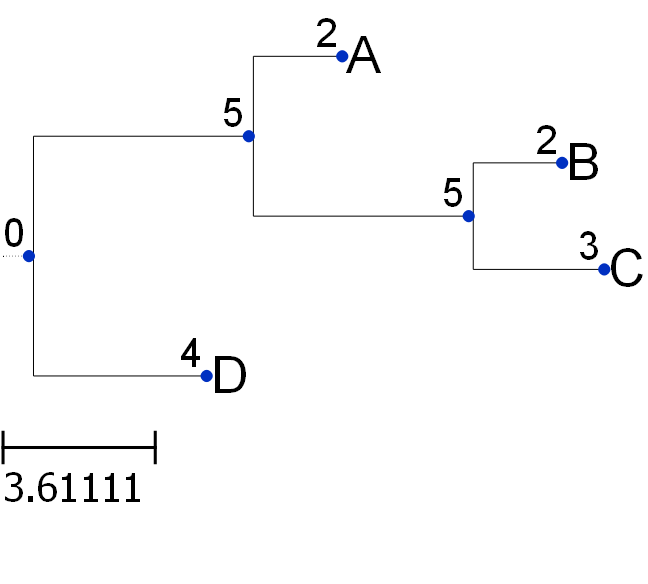

In [263]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 5 :** Reécrivez l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](input/tree.png)

In [5]:
from ete3 import Tree, TreeStyle

# Création d'un objet arbre au format newick
newick_tree = '((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2):0;'

# Construction de l'arbre à partir de la chaîne newick
t = Tree(newick_tree)

# Création d'un objet pour personnaliser l'affichage de l'arbre
ts = TreeStyle()

# Affichage des longueurs des branches de l'arbre
ts.show_branch_length = True

# Affichage de l'arbre dans le notebook
t.render('%%inline', w=183, units='mm', tree_style=ts)

TypeError: arguments did not match any overloaded call:
  QImage(): too many arguments
  QImage(size: QSize, format: QImage.Format): argument 1 has unexpected type 'float'
  QImage(width: int, height: int, format: QImage.Format): argument 1 has unexpected type 'float'
  QImage(data: bytes, width: int, height: int, format: QImage.Format): argument 1 has unexpected type 'float'
  QImage(data: PyQt5.sip.voidptr, width: int, height: int, format: QImage.Format): argument 1 has unexpected type 'float'
  QImage(data: bytes, width: int, height: int, bytesPerLine: int, format: QImage.Format): argument 1 has unexpected type 'float'
  QImage(data: PyQt5.sip.voidptr, width: int, height: int, bytesPerLine: int, format: QImage.Format): argument 1 has unexpected type 'float'
  QImage(xpm: List[str]): argument 1 has unexpected type 'float'
  QImage(fileName: str, format: typing.Optional[str] = None): argument 1 has unexpected type 'float'
  QImage(a0: QImage): argument 1 has unexpected type 'float'
  QImage(variant: Any): too many arguments

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse :  En examinant l'arbre, on constate que A, B et C partagent un ancêtre commun. L'hypothèse la plus courante qui explique un tel embranchement est que les séquences A, B et C ont évolué à partir d'un ancêtre commun plus récent que l'ancêtre commun à toutes les autres séquences. Cela signifie que les séquences A, B et C ont eu moins de temps pour accumuler des différences génétiques, d'où leur regroupement dans une branche. Les séquences D, E et F, quant à elles, ont eu plus de temps pour accumuler des différences génétiques et ont donc divergé plus significativement les unes des autres.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

In [274]:
def UPGMA(Mat):
    Min = M[1][0]
    for i in range(len(Mat[0])):
        for j in range(len(Mat[0])):
            if (M[i][j] < Min) and M[i][j] != 0:
                Min = M[i][j]
    return Min

M = np.array([[0,4,8,2],[4,0,8,4],[8,8,0,8],[2,4,8,0]])
print(M)
UPGMA(M)

[[0 4 8 2]
 [4 0 8 4]
 [8 8 0 8]
 [2 4 8 0]]


2

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : UPGMA fait plusieurs hypothèses sur les données :

- Toutes les séquences évoluent à un taux de changement similaire.
- La distance entre deux groupes est proportionnelle à la durée depuis leur divergence.
- Aucune perte de branche n'est autorisée.

Dans le cas présent, les données ne semblent pas respecter la première hypothèse, car il est peu probable que toutes les séquences évoluent à un taux de changement similaire. De plus, l'absence de pertes de branches peut également être remise en question, car il est possible que certaines séquences aient perdu des régions importantes au fil du temps.

Cependant, malgré ces hypothèses simplificatrices, UPGMA reste un algorithme utile pour obtenir une approximation de l'arbre phylogénétique, en particulier lorsque les données sont limitées. Il est important de noter que d'autres méthodes plus avancées existent pour prendre en compte la complexité des données, telles que les méthodes bayésiennes et maximum de vraisemblance.


----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

**Réponse :** Une autre méthode courante pour enraciner un arbre est l'utilisation d'une racine externe ou d'une racine interne, par exemple en utilisant une espèce extérieure au groupe étudié ou en choisissant une espèce de référence comme racine interne. Cependant, dans le cas présent, nous ne disposons pas des informations nécessaires pour effectuer un enracinement avec cette méthode.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [35]:
import numpy as np

def neighbor_joining(D):
    """
    Implémentation de l'algorithme neighbor-joining pour calculer un arbre phylogénique à partir d'une matrice de distance D.

    Args:
        D (array-like): Matrice de distance.

    Returns:
        dict: Dictionnaire représentant l'arbre phylogénique.
    """

    def find_min(D):
        """
        Trouve l'élément de distance minimale dans la matrice de distance.

        Args:
            D (array-like): Matrice de distance.

        Returns:
            tuple: Tuple contenant l'indice de l'élément de distance minimale dans la matrice et cette distance minimale.
        """
        n = D.shape[0]
        min_val = np.inf
        min_index = (-1, -1)

        for i in range(n):
            for j in range(i + 1, n):
                if D[i, j] < min_val:
                    min_val = D[i, j]
                    min_index = (i, j)

        return min_index, min_val

    def compute_Q(D):
        """
        Calcule la matrice Q pour l'algorithme neighbor-joining.

        Args:
            D (array-like): Matrice de distance.

        Returns:
            array-like: Matrice Q.
        """
        n = D.shape[0]
        Q = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                s_i = np.sum(D[i, :])
                s_j = np.sum(D[j, :])
                Q[i, j] = (n - 2) * D[i, j] - s_i - s_j
                Q[j, i] = Q[i, j]

        return Q

    def update_D(D, i, j):
        """
        Met à jour la matrice de distance D pour l'algorithme neighbor-joining.

        Args:
            D (array-like): Matrice de distance.
            i (int): Indice du premier élément à fusionner.
            j (int): Indice du deuxième élément à fusionner.

        Returns:
            array-like: Matrice de distance mise à jour.
        """
        n = D.shape[0]
        new_D = np.zeros((n - 1, n - 1), dtype=float)
        row = 0

        for k in range(n):
            if k not in (i, j):
                new_D[row, -1] = (D[i, k] + D[j, k] - D[i, j]) / 2
                new_D[-1, row] = new_D[row, -1]
                row += 1

        for k in range(n - 1):
            if k != row:
                new_D[k, :k] = D[k, :k]
                new_D[k, k+1:] = D[k, k+1:]

        return new_D

    def construct_tree(D):
        """
        Construit l'arbre phylogénique à partir de la matrice de distance.

        Args:
            D (array-like): Matrice de distance.

        Returns:
            dict: Dictionnaire représentant l'arbre phylogénique.
        """
        if D.shape == (2, 2):
            return {'name': None, 'branch_length': D[0, 1]}

        n = D.shape[0]
        Q = compute_Q(D)    # Trouver l'élément de distance minimale dans la matrice Q
        min_index = np.unravel_index(np.argmin(Q), Q.shape)
        i, j = min_index

        # Calculer les distances entre les nouveaux éléments fusionnés et les anciens éléments
        d_i = 0.5 * D[i, j] + (1 / (2 * (n - 2))) * (np.sum(D[i, :]) - np.sum(D[j, :]))
        d_j = D[i, j] - d_i
        new_row = np.zeros((1, n-1))
        new_row[0, :j] = 0.5 * (D[i, :j] + D[j, :j] - D[i, j])
        new_row[0, j+1:] = 0.5 * (D[i, j+1:] + D[j, j+1:] - D[i, j])
        new_D = np.vstack([np.hstack([D[:j, :j], new_row.T, D[:j, j+1:]]),
                        np.hstack([new_row, np.zeros((1, 1)), np.atleast_2d(d_i + d_j)]),
                        np.hstack([D[j+1:, :j], np.atleast_2d(d_i + d_j), D[j+1:, j+1:]])])

        # Construire l'arbre phylogénique récursivement
        left = construct_tree(new_D[:j+1, :j+1])
        right = construct_tree(new_D[j+1:, j+1:])
        node_name = None

        return {'name': node_name, 'children': [left, right], 'branch_length': d_i}

    return construct_tree(D)

M = np.array([[0,4,8,2],[4,0,8,4],[8,8,0,8],[2,4,8,0]])
assert np.allclose(M, M.T)   # Vérifie la symétrie
assert np.all(np.diag(M) == 0)   # Vérifie que la diagonale est nulle
assert np.all(M >= 0)   # Vérifie que tous les éléments sont positifs ou nuls
print(neighbor_joining(M))


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 1 has size 1

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 11 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse :